# Ungraded Lab: Decision Trees

In this notebook you will visualize how a decision tree is splitted using information gain.

We will revisit the dataset used in the video lectures. The dataset is:

As you saw in the lectures, in a decision tree, we decide if a node will be split or not by looking at the **information gain** that split would give us. (Image of video IG)

Where 

$$\text{Information Gain} = H(p_1^\text{node})- \left(w^{\text{left}}H\left(p_1^\text{left}\right) + w^{\text{right}}H\left(p_1^\text{right}\right)\right),$$

and $H$ is the entropy, defined as

$$H(p_1) = -p_1 \text{log}_2(p_1) - (1- p_1) \text{log}_2(1- p_1)$$

Remember that log here is defined to be in base 2. Run the code block below to see by yourself how the entropy. $H(p)$ behaves while $p$ varies.

Note that the H attains its higher value when $p = 0.5$. This means that the probability of event is $0.5$. And its minimum value is attained in $p = 0$ and $p = 1$, i.e., the probability of the event happening is totally predictable. Thus, the entropy shows the degree of predictability of an event.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import *

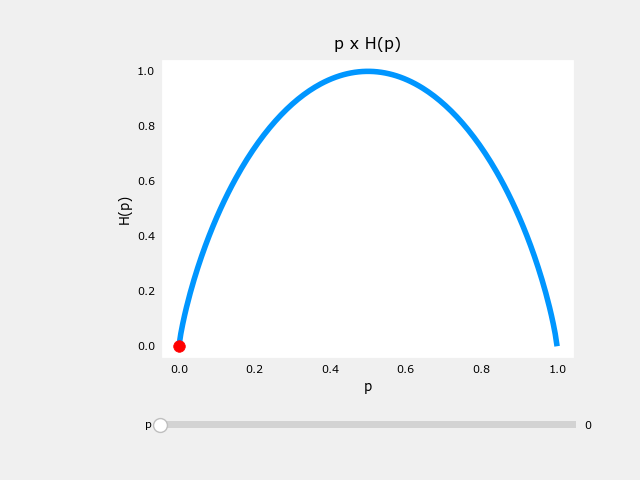

In [3]:
%matplotlib widget
_ = plot_entropy()


|                                                     |   Ear Shape | Face Shape | Whiskers |   Cat  |
|:---------------------------------------------------:|:---------:|:-----------:|:---------:|:------:|
| <img src="images/0.png" alt="drawing" width="50"/> |   Pointy   |   Round     |  Present  |    1   |
| <img src="images/1.png" alt="drawing" width="50"/> |   Floppy   |  Not Round  |  Present  |    1   |
| <img src="images/2.png" alt="drawing" width="50"/> |   Floppy   |  Round      |  Absent   |    0   |
| <img src="images/3.png" alt="drawing" width="50"/> |   Pointy   |  Not Round  |  Present  |    0   |
| <img src="images/4.png" alt="drawing" width="50"/> |   Pointy   |   Round     |  Present  |    1   |
| <img src="images/5.png" alt="drawing" width="50"/> |   Pointy   |   Round     |  Absent   |    1   |
| <img src="images/6.png" alt="drawing" width="50"/> |   Floppy   |  Not Round  |  Absent   |    0   |
| <img src="images/7.png" alt="drawing" width="50"/> |   Pointy   |  Round      |  Absent   |    1   |
| <img src="images/8.png" alt="drawing" width="50"/> |    Floppy  |   Round     |  Absent   |    0   |
| <img src="images/9.png" alt="drawing" width="50"/> |   Floppy   |  Round      |  Absent   |    0   |


We will use **one-hot encoding** to encode the categorical features. They will be as follows:

- Ear Shape: Pointy = 1, Floppy = 0
- Face Shape: Round = 1, Not Round = 0
- Whiskers: Present = 1, Absent = 0

Therefore, we have two sets:

- `X_train`: for each example, contains 3 features:
            - Ear Shape (1 if pointy, 0 otherwise)
            - Face Shape (1 if round, 0 otherwise)
            - Whiskers (1 if present, 0 otherwise)
            
- `y_train`: whether the animal is a cat
            - 1 if the animal is a cat
            - 0 otherwise

In [5]:
X_train = np.array([[1, 1, 1],
[0, 0, 1],
 [0, 1, 0],
 [1, 0, 1],
 [1, 1, 1],
 [1, 1, 0],
 [0, 0, 0],
 [1, 1, 0],
 [0, 1, 0],
 [0, 1, 0]])

y_train = np.array([1, 1, 0, 0, 1, 1, 0, 1, 0, 0])

In [6]:
#For instance, the first example
X_train[0]

array([1, 1, 1])

This means that the first example has a pointy ear shape, round face shape and it has whiskers.

On each node, we compute the information gain for each feature, then split the node on the feature with the higher information gain, by comparing the entropy of the node with the weighted entropy in the two splitted nodes. 

So, the root node has every animal in our dataset. Remember that $p_1^{node}$ is the proportion of positive class (cats) in the root node. So

$$p_1^{node} = \frac{5}{10} = 0.5$$

Now let's write a function to compute the entropy.

In [7]:
def entropy(p):
    if p == 0 or p == 1:
        return 0
    else:
        return -p * np.log2(p) - (1- p)*np.log2(1 - p)
    
print(entropy(0.5))

1.0


To illustrate, let's compute the information gain if we split the node for each of the features. To do this, let's write some functions.

In [8]:
def split_indices(X, index_feature):
    """Given a dataset and a index feature, return two lists for the two split nodes, the left node has the animals that have 
    that feature = 1 and the right node those that have the feature = 0 
    index feature = 0 => ear shape
    index feature = 1 => face shape
    index feature = 2 => whiskers
    """
    left_indices = []
    right_indices = []
    for i,x in enumerate(X):
        if x[index_feature] == 1:
            left_indices.append(i)
        else:
            right_indices.append(i)
    return left_indices, right_indices

So, if we choose Ear Shape to split, then we must have in the left node (check the table above) the indices:

$$0 \quad 3 \quad 4 \quad 5 \quad 7$$

and the right indices, the remaining ones.

In [9]:
split_indices(X_train, 0)

([0, 3, 4, 5, 7], [1, 2, 6, 8, 9])

Now we need another function to compute the weighted entropy in the splitted nodes. As you've seen in the video lecture, we must find:

- $w^{\text{left}}$ and $w^{\text{right}}$, the proportion of animals in **each node**.
- $p^{\text{left}}$ and $p^{\text{right}}$, the proportion of cats in **each split**.

Note the difference between these two definitions!! To illustrate, if we split the root node on the feature of index 0 (Ear Shape), then in the left node, the one that has the animals 0, 3, 4, 5 and 7, we have:

$$w^{\text{left}}= \frac{5}{10} = 0.5 \text{ and } p^{\text{left}} = \frac{4}{5}$$
$$w^{\text{right}}= \frac{5}{10} = 0.5 \text{ and } p^{\text{right}} = \frac{1}{5}$$

In [10]:
def weighted_entropy(X,y,left_indices,right_indices):
    """
    This function takes the splitted dataset, the indices we chose to split and returns the weighted entropy.
    """
    w_left = len(left_indices)/len(X)
    w_right = len(right_indices)/len(X)
    p_left = sum(y[left_indices])/len(left_indices)
    p_right = sum(y[right_indices])/len(right_indices)
    
    weighted_entropy = w_left * entropy(p_left) + w_right * entropy(p_right)
    return weighted_entropy

In [11]:
left_indices, right_indices = split_indices(X_train, 0)
weighted_entropy(X_train, y_train, left_indices, right_indices)

0.7219280948873623

So, the weighted entropy in the 2 split nodes is 0.72. To compute the **Information Gain** we must subtract it from the entropy in the node we chose to split (in this case, the root node). 

In [12]:
def information_gain(X, y, left_indices, right_indices):
    """
    Here, X has the elements in the node and y is theirs respectives classes
    """
    p_node = sum(y)/len(y)
    h_node = entropy(p_node)
    w_entropy = weighted_entropy(X,y,left_indices,right_indices)
    return h_node - w_entropy

In [13]:
information_gain(X_train, y_train, left_indices, right_indices)

0.2780719051126377

Now, let's compute the information gain if we split the root node for each feature:

In [14]:
for i, feature_name in enumerate(['Ear Shape', 'Face Shape', 'Whiskers']):
    left_indices, right_indices = split_indices(X_train, i)
    i_gain = information_gain(X_train, y_train, left_indices, right_indices)
    print(f"Feature: {feature_name}, information gain if we split the root node using this feature: {i_gain:.2f}")
    

Feature: Ear Shape, information gain if we split the root node using this feature: 0.28
Feature: Face Shape, information gain if we split the root node using this feature: 0.03
Feature: Whiskers, information gain if we split the root node using this feature: 0.12


So, the best feature to split is indeed the Ear Shape. Run the code below to see the split in action. You do not need to understand the following code block. 

 Depth 0, Root: Split on feature: 0
 - Left leaf node with indices [0, 3, 4, 5, 7]
 - Right leaf node with indices [1, 2, 6, 8, 9]


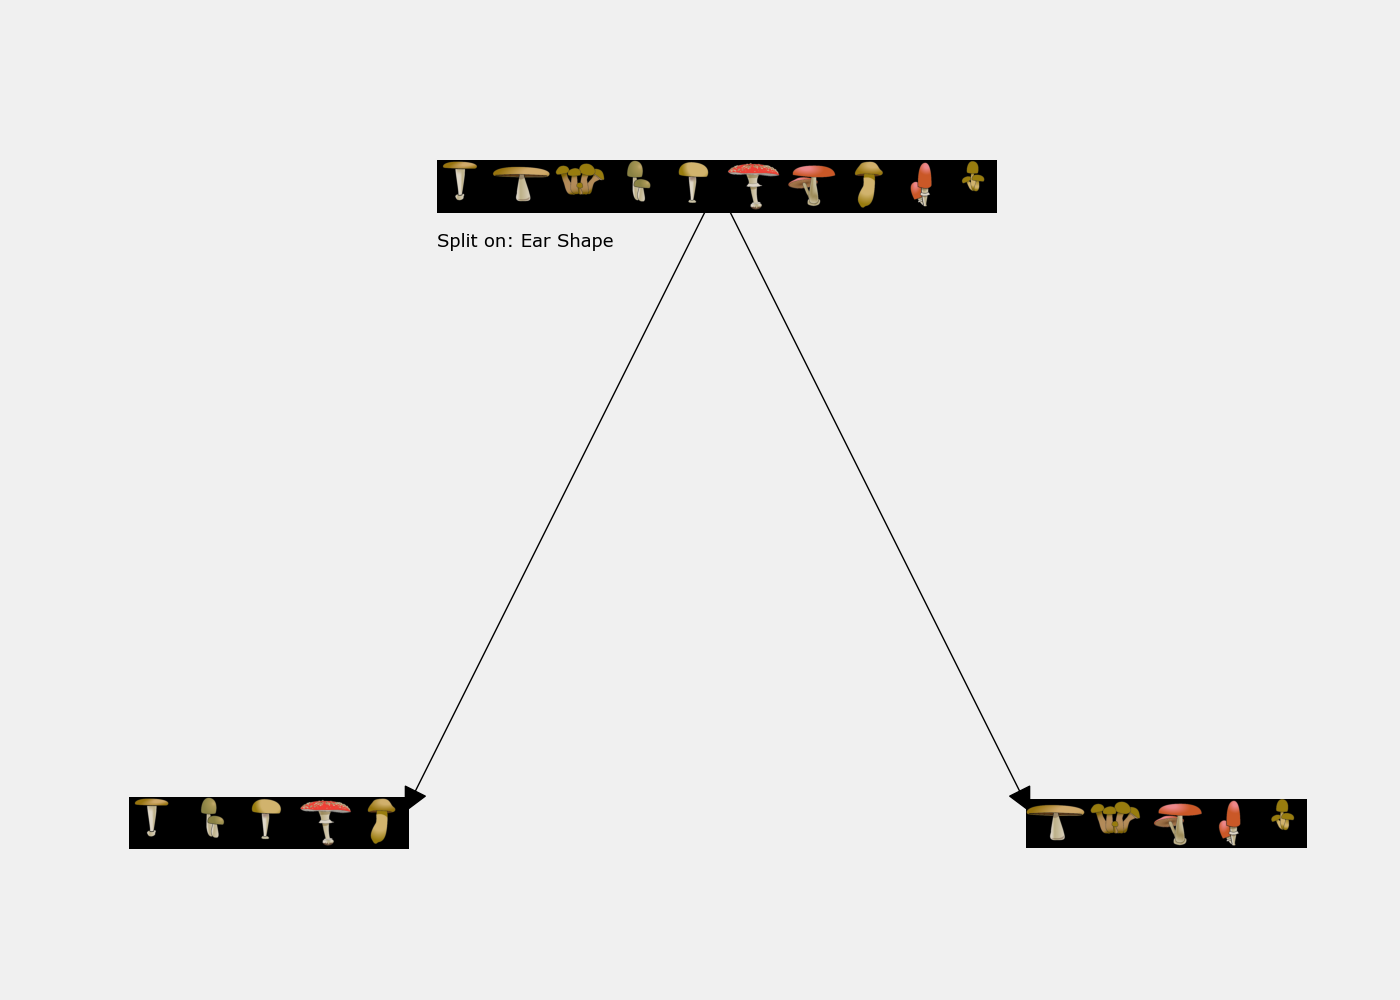

In [15]:
tree = []
build_tree_recursive(X_train, y_train, [0,1,2,3,4,5,6,7,8,9], "Root", max_depth=1, current_depth=0, tree = tree)
generate_tree_viz([0,1,2,3,4,5,6,7,8,9], y_train, tree)

The process is **recursive**, which means we must perform these calculations for each node until we meet a stopping criteria:

- If the tree depth after splitting exceeds a threshold
- If the resulting node has only 1 class
- If the information gain of splitting is below a threshold

The final tree looks like this:

 Depth 0, Root: Split on feature: 0
- Depth 1, Left: Split on feature: 1
  -- Left leaf node with indices [0, 4, 5, 7]
  -- Right leaf node with indices [3]
- Depth 1, Right: Split on feature: 2
  -- Left leaf node with indices [1]
  -- Right leaf node with indices [2, 6, 8, 9]


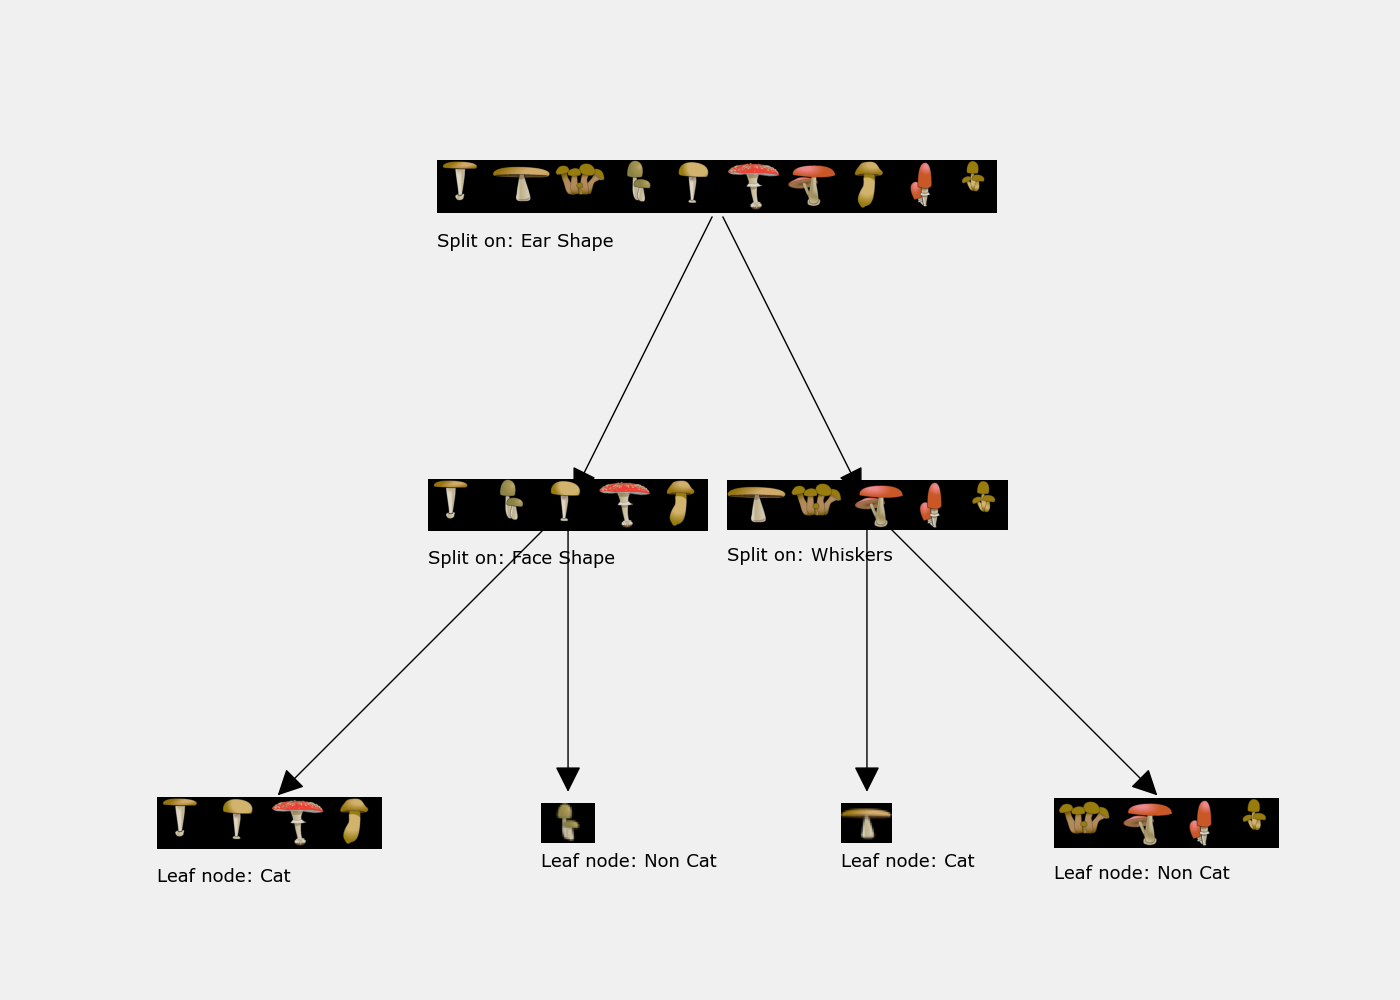

In [16]:
tree = []
build_tree_recursive(X_train, y_train, [0,1,2,3,4,5,6,7,8,9], "Root", max_depth=2, current_depth=0, tree = tree)
generate_tree_viz([0,1,2,3,4,5,6,7,8,9], y_train, tree)

Congratulations! You completed the notebook!

# Optional Lab - Trees Ensemble

In this notebook, you will:

 - Use Pandas to perform one-hot encoding of a dataset
 - Use scikit-learn to implement a Decision Tree, Random Forest and XGBoost models

Let's import the libraries you will use.

In [17]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
!pip install xgboost --quiet
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
plt.style.use('./deeplearning.mplstyle')

RANDOM_STATE = 55 ## You will pass it to every sklearn call so we ensure reproducibility

# 1. Loading the Dataset

From [Kaggle](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction)

Context
Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worldwide. Heart failure is a common event caused by CVDs and this dataset contains 11 features that can be used to predict a possible heart disease.

People with cardiovascular disease or who are at high cardiovascular risk need early detection and management wherein a machine learning model can be of great help.

You will develop models to predict how likely a particular person is in developint cardiovascular disease, given all the information below.

#### Attribute Information
- Age: age of the patient [years]
- Sex: sex of the patient [M: Male, F: Female]
- ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- HeartDisease: output class [1: heart disease, 0: Normal]

Let's now load the dataset. As you can see above, the variables:

- Sex
- ChestPainType
- RestingECG
- ExerciseAngina
- ST_Slope

Are *categorical*, so you must one-hot encode them. 

In [18]:
# Load the dataset using pandas
df = pd.read_csv("heart.csv")

In [19]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


You must perform some data engineering before working with the models. There are 5 categorical features, so you will use Pandas to one-hot encode them.

## 2. One-hot encoding using Pandas

First you will remove the binary variables, because one-hot encoding them would do nothing to them. To achieve this you will just count how many different values there are in each categorical variable and consider only the variables with 3 or more values.

In [20]:
cat_variables = ['Sex',
'ChestPainType',
'RestingECG',
'ExerciseAngina',
'ST_Slope'
]

As a reminder, one-hot encoding aims to transform a categorical variable with `n` outputs into `n` binary variables.

Pandas has a built-in method to one-hot encode variables, it is the function `pd.get_dummies`. There are several arguments to this function, but here you will use only a few. They are:

 - data: DataFrame to be used
 - prefix: A list with prefixes, so you know which value you are dealing with
 - columns: the list of columns that will be one-hot encoded. 'prefix' and 'columns' must have the same length.
 
For more information, you can always type `help(pd.get_dummies)` to read the function's full documentation.

In [21]:
# This will replace the columns with the one-hot encoded ones and keep the columns outside 'columns' argument as it is.
df = pd.get_dummies(data = df,
                         prefix = cat_variables,
                         columns = cat_variables)

In [22]:
df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,False,True,False,...,False,False,False,True,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1,True,False,False,...,True,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,False,True,False,...,False,False,False,False,True,True,False,False,False,True
3,48,138,214,0,108,1.5,1,True,False,True,...,False,False,False,True,False,False,True,False,True,False
4,54,150,195,0,122,0.0,0,False,True,False,...,True,False,False,True,False,True,False,False,False,True


You now will define the final set of variables that will be used by the models you will build in this lab.

In [23]:
var = [x for x in df.columns if x not in 'HeartDisease'] ## Removing our target variable

Note how the number of variables has changed. You started with 11 variables now you have:

In [24]:
print(len(var))

20


# 3. Splitting the Dataset

In this section, you will split our dataset into train and test datasets. You will use the function `train_test_split` from Scikit-learn. Let's just check its arguments.

In [25]:
help(train_test_split)

Help on function train_test_split in module sklearn.model_selection._split:

train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)
    Split arrays or matrices into random train and test subsets.

    Quick utility that wraps input validation,
    ``next(ShuffleSplit().split(X, y))``, and application to input data
    into a single call for splitting (and optionally subsampling) data into a
    one-liner.

    Read more in the :ref:`User Guide <cross_validation>`.

    Parameters
    ----------
    *arrays : sequence of indexables with same length / shape[0]
        Allowed inputs are lists, numpy arrays, scipy-sparse
        matrices or pandas dataframes.

    test_size : float or int, default=None
        If float, should be between 0.0 and 1.0 and represent the proportion
        of the dataset to include in the test split. If int, represents the
        absolute number of test samples. If None, the value is set to the
        com

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df[var], df['HeartDisease'], train_size = 0.8, random_state = RANDOM_STATE)

# We will keep the shuffle = True since our dataset has not any time dependency.

In [27]:
print(f'train samples: {len(X_train)}\ntest samples: {len(X_test)}')
print(f'target proportion: {sum(y_train)/len(y_train):.4f}')

train samples: 734
test samples: 184
target proportion: 0.5518


# 4. Building the Models

## 4.1 Decision Tree

In this section, let's work with the Decision Tree you previously learned, but now using the [Scikit-learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). 

There are several hyperparameters in the Decision Tree object from Scikit-learn. You will use only some of them and also you will not perform feature selection nor hyperparameter tuning in this lab (but you are encouraged to do so and compare the results :-) )


The hyperparameters you will use and investigate here is:

 - min_samples_split: The minimum number of samples required to split an internal node. This may prevent overfitting.
 - max_depth: The maximum depth of the tree. This may prevent overfitting.

In [28]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700] ## If the number is an integer, then it is the actual quantity of samples,
max_depth_list = [1,2, 3, 4, 8, 16, 32, 64, None] # None means that there is no depth limit.

In [29]:
accuracy_list_train = []
accuracy_list_test = []
for min_samples_split in min_samples_split_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = DecisionTreeClassifier(min_samples_split = min_samples_split,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_test = model.predict(X_test) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_test = accuracy_score(predictions_test,y_test)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_test.append(accuracy_test)

plt.title('Train x Test metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_test)
plt.legend(['Train','Test'])

Note how increasing the the number of `min_samples_split` decreases the overfit. 

Let's do the same experiment with `max_depth`.

In [30]:
accuracy_list_train = []
accuracy_list_test = []
for max_depth in max_depth_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = DecisionTreeClassifier(max_depth = max_depth,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_test = model.predict(X_test) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_test = accuracy_score(predictions_test,y_test)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_test.append(accuracy_test)

plt.title('Train x Test metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_test)
plt.legend(['Train','Test'])

The test accuracy reaches the highest at tree_depth=3. When the allowed depth is smaller, the tree cannot make enough splits to distinguish positives from negatives (having the underfit problem), but when the allowed depth is too high ( >= 5), the tree becomes too specialized to the training set and thus losing accuracy to the test dataset (having the overfit problem). Our final tree model then will have:

- `max_depth = 3`
- `min_samples_split = 50` 

In [31]:
decision_tree_model = DecisionTreeClassifier(min_samples_split = 50,
                                             max_depth = 3,
                                             random_state = RANDOM_STATE).fit(X_train,y_train)

In [32]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_test),y_test):.4f}")

Metrics train:
	Accuracy score: 0.8583
Metrics test:
	Accuracy score: 0.8641


No sign of overfit, even though the metrics are not that good.

## 4.2 Random Forest

Now let's try the Random Forest algorithm also, using the Scikit-learn implementation. Naturally, all of the above hyperparameters will exist in this algorithm, since it is just an ensemble of Decision Trees, but will have another hyperparameter that you will use, called `n_estimators` which is how many different Decision Trees will be fitted. 

Remember that for a Random Forest, you use a subset of the features AND a subset of the training set to train each tree, chosen randomly. In this case, you will use the number of features as you saw in the lecture, which is $\sqrt{n}$ where $n$ is the number of features. However, this can be modified. For further information on the Random Forest hyperparameters, you can run `help(RandomForestClassifier)`.

Another parameter that does not impact on the final result but can speed up the computation is called `n_jobs`. Since the fitting of each tree is independent of each other, it is possible to run parallel fits. So setting `n_jobs` higher will increase how many CPU cores it will use. Note that the numbers very close to the maximum cores of your CPU may impact on the overall performance of your PC and even lead to freezes. 

You will run the same script again, but with another parameter, `n_estimators`, where we will choose between 10, 50, and 100. The default is 100.

In [33]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700]  ## If the number is an integer, then it is the actual quantity of samples,
                                             ## If it is a float, then it is the percentage of the dataset
max_depth_list = [2, 4, 8, 16, 32, 64, None]
n_estimators_list = [10,50,100,500]

In [34]:
accuracy_list_train = []
accuracy_list_test = []
for min_samples_split in min_samples_split_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(min_samples_split = min_samples_split,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_test = model.predict(X_test) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_test = accuracy_score(predictions_test,y_test)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_test.append(accuracy_test)

plt.title('Train x Test metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list) 
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_test)
plt.legend(['Train','Test'])

In [35]:
accuracy_list_train = []
accuracy_list_test = []
for max_depth in max_depth_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(max_depth = max_depth,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_test = model.predict(X_test) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_test = accuracy_score(predictions_test,y_test)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_test.append(accuracy_test)

plt.title('Train x Test metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_test)
plt.legend(['Train','Test'])

In [36]:
accuracy_list_train = []
accuracy_list_test = []
for n_estimators in n_estimators_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(n_estimators = n_estimators,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_test = model.predict(X_test) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_test = accuracy_score(predictions_test,y_test)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_test.append(accuracy_test)

plt.title('Train x Test metrics')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(n_estimators_list )),labels=n_estimators_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_test)
plt.legend(['Train','Test'])

Let's then fit a random forest with the following parameters:

 - max_depth: 8
 - min_samples_split: 10
 - n_estimators: 100

In [37]:
random_forest_model = RandomForestClassifier(n_estimators = 100,
                                             max_depth = 8, 
                                             min_samples_split = 10).fit(X_train,y_train)

In [38]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(random_forest_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(random_forest_model.predict(X_test),y_test):.4f}")

Metrics train:
	Accuracy score: 0.9237
Metrics test:
	Accuracy score: 0.8913


You have demonstrated how to look for the best value hyperparameter-by-hyperparameter. However, you should not overlook that as we experiment with one hyperparameter we always have to fix the others at some default values. This makes us only able to tell how the hyperparameter value changes with respect to those defaults. In princple, if you have 4 values to try out in each of the 3 hyperparameters being tuned, you should have a total of 4 x 4 x 4 = 64 combinations, however, the way you are doing will only give us 4 + 4 + 4 = 12 results. To try out all combinations, you can use a sklearn implementation called GridSearchCV, moreover, it has a refit parameter that will automatically refit a model on the best combination so you will not need to program it explicitly. For more on GridSearchCV, please refer to its [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

## 4.3 XGBoost

Now, the last model you will test in this lab is the Gradient Boosting model, called XGBoost. As you've seen in the lectures, the boosting methods train several trees, but instead of them being uncorrelated to each other, now the trees are fitted subsequently to minimize the error. 

The parameters that this model comprises is the same as the parameters for any decision tree, plus some others, such as the learning rate, which is the size of the step on the Gradient Descent method that the XGBoost uses internally to minimize the error on each train step.

One interesting thing about the XGBoost is that it allows, during the fit, to pass a list evaluation datasets of the form `(X_val,y_val)`, where on each iteration, it measures the cost (or evaluation metric) on the evaluation datasets so that once the cost (or metric) stops to descrease for a number of rounds (called early_stopping_rounds), the training will stop. This is how we can automatically control how many estimators is enough, and how we can avoid overfitting due to too many estimators.

First, let's define a subset of our training set (we should not use the test set here).

In [39]:
n = int(len(X_train)*0.8) ## Let's use 80% to train and 20% to eval

In [40]:
X_train_fit, X_train_eval, y_train_fit, y_train_eval = X_train[:n], X_train[n:], y_train[:n], y_train[n:]

You can then set a large number of estimators, because you can stop if the cost function stops decreasing.

In [41]:
xgb_model = XGBClassifier(n_estimators = 500, learning_rate = 0.1,verbosity = 1, random_state = RANDOM_STATE)
xgb_model.fit(X_train_fit,y_train_fit, eval_set = [(X_train_eval,y_train_eval)], early_stopping_rounds = 50)
# Here we must pass a list to the eval_set, because you can have several different tuples ov eval sets. The parameter 
# early_stopping_rounds is the number of iterations that it will wait to check if the cost function decreased or not.
# If not, it will stop and get the iteration that returned the lowest metric on the eval set.

TypeError: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

As you can see, even though you passed 500 estimators to fit, the algorithm only fitted 66 because the log-loss used to metrify the training rounds started to increase. In fact, the number of estimators is even less than 66. If you take a closeer look to the metrics, you see that with 16 fitted trees, we achieved the minimum value of the log-loss, and in fact, this is the number of fitted trees in the final model:

In [42]:
xgb_model.best_iteration

NotFittedError: need to call fit or load_model beforehand

In [43]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_test),y_test):.4f}")

NotFittedError: need to call fit or load_model beforehand

You can see that RandomForest achieved the best accuracy, but the results overall were close. And note that we got a very close test metric with XGBoost compared to RandomForest, and we didn't even performed any hyperparameter search! The advantage of XGBoost is that it is faster than the Random Forest and also it has more parameters, therefore you are able to fine-tune the model to achieve even better results.


Congratulations, you have learned how to use Decision Tree, Random Forest from the scikit-learn library and XGBoost!

# Practice Lab: Decision Trees

In this exercise, you will implement a decision tree from scratch and apply it to the task of classifying whether a mushroom is edible or poisonous.

# Outline
- [ 1 - Packages ](#1)
- [ 2 -  Problem Statement](#2)
- [ 3 - Dataset](#3)
  - [ 3.1 One hot encoded dataset](#3.1)
- [ 4 - Decision Tree Refresher](#4)
  - [ 4.1  Calculate entropy](#4.1)
    - [ Exercise 1](#ex01)
  - [ 4.2  Split dataset](#4.2)
    - [ Exercise 2](#ex02)
  - [ 4.3  Calculate information gain](#4.3)
    - [ Exercise 3](#ex03)
  - [ 4.4  Get best split](#4.4)
    - [ Exercise 4](#ex04)
- [ 5 - Building the tree](#5)


_**NOTE:** To prevent errors from the autograder, you are not allowed to edit or delete non-graded cells in this notebook . Please also refrain from adding any new cells. 
**Once you have passed this assignment** and want to experiment with any of the non-graded code, you may follow the instructions at the bottom of this notebook._

<a name="1"></a>
## 1 - Packages 

First, let's run the cell below to import all the packages that you will need during this assignment.
- [numpy](https://www.numpy.org) is the fundamental package for working with matrices in Python.
- [matplotlib](https://matplotlib.org) is a famous library to plot graphs in Python.
- ``utils.py`` contains helper functions for this assignment. You do not need to modify code in this file.


In [44]:
import numpy as np
import matplotlib.pyplot as plt
from public_tests import *
from utils import *

%matplotlib inline

<a name="2"></a>
## 2 -  Problem Statement

Suppose you are starting a company that grows and sells wild mushrooms. 
- Since not all mushrooms are edible, you'd like to be able to tell whether a given mushroom is edible or poisonous based on it's physical attributes
- You have some existing data that you can use for this task. 

Can you use the data to help you identify which mushrooms can be sold safely? 

Note: The dataset used is for illustrative purposes only. It is not meant to be a guide on identifying edible mushrooms.



<a name="3"></a>
## 3 - Dataset

You will start by loading the dataset for this task. The dataset you have collected is as follows:

|                                                     | Cap Color | Stalk Shape | Solitary | Edible |
|:---------------------------------------------------:|:---------:|:-----------:|:--------:|:------:|
| <img src="images/0.png" alt="drawing" width="50"/> |   Brown   |   Tapering  |    Yes   |    1   |
| <img src="images/1.png" alt="drawing" width="50"/> |   Brown   |  Enlarging  |    Yes   |    1   |
| <img src="images/2.png" alt="drawing" width="50"/> |   Brown   |  Enlarging  |    No    |    0   |
| <img src="images/3.png" alt="drawing" width="50"/> |   Brown   |  Enlarging  |    No    |    0   |
| <img src="images/4.png" alt="drawing" width="50"/> |   Brown   |   Tapering  |    Yes   |    1   |
| <img src="images/5.png" alt="drawing" width="50"/> |    Red    |   Tapering  |    Yes   |    0   |
| <img src="images/6.png" alt="drawing" width="50"/> |    Red    |  Enlarging  |    No    |    0   |
| <img src="images/7.png" alt="drawing" width="50"/> |   Brown   |  Enlarging  |    Yes   |    1   |
| <img src="images/8.png" alt="drawing" width="50"/> |    Red    |   Tapering  |    No    |    1   |
| <img src="images/9.png" alt="drawing" width="50"/> |   Brown   |  Enlarging  |    No    |    0   |


-  You have 10 examples of mushrooms. For each example, you have
    - Three features
        - Cap Color (`Brown` or `Red`),
        - Stalk Shape (`Tapering (as in \/)` or `Enlarging (as in /\)`), and
        - Solitary (`Yes` or `No`)
    - Label
        - Edible (`1` indicating yes or `0` indicating poisonous)

<a name="3.1"></a>
### 3.1 One hot encoded dataset
For ease of implementation, we have one-hot encoded the features (turned them into 0 or 1 valued features)

|                                                    | Brown Cap | Tapering Stalk Shape | Solitary | Edible |
|:--------------------------------------------------:|:---------:|:--------------------:|:--------:|:------:|
| <img src="images/0.png" alt="drawing" width="50"/> |     1     |           1          |     1    |    1   |
| <img src="images/1.png" alt="drawing" width="50"/> |     1     |           0          |     1    |    1   |
| <img src="images/2.png" alt="drawing" width="50"/> |     1     |           0          |     0    |    0   |
| <img src="images/3.png" alt="drawing" width="50"/> |     1     |           0          |     0    |    0   |
| <img src="images/4.png" alt="drawing" width="50"/> |     1     |           1          |     1    |    1   |
| <img src="images/5.png" alt="drawing" width="50"/> |     0     |           1          |     1    |    0   |
| <img src="images/6.png" alt="drawing" width="50"/> |     0     |           0          |     0    |    0   |
| <img src="images/7.png" alt="drawing" width="50"/> |     1     |           0          |     1    |    1   |
| <img src="images/8.png" alt="drawing" width="50"/> |     0     |           1          |     0    |    1   |
| <img src="images/9.png" alt="drawing" width="50"/> |     1     |           0          |     0    |    0   |


Therefore,
- `X_train` contains three features for each example 
    - Brown Color (A value of `1` indicates "Brown" cap color and `0` indicates "Red" cap color)
    - Tapering Shape (A value of `1` indicates "Tapering Stalk Shape" and `0` indicates "Enlarging" stalk shape)
    - Solitary  (A value of `1` indicates "Yes" and `0` indicates "No")

- `y_train` is whether the mushroom is edible 
    - `y = 1` indicates edible
    - `y = 0` indicates poisonous

In [45]:
X_train = np.array([[1,1,1],[1,0,1],[1,0,0],[1,0,0],[1,1,1],[0,1,1],[0,0,0],[1,0,1],[0,1,0],[1,0,0]])
y_train = np.array([1,1,0,0,1,0,0,1,1,0])

#### View the variables
Let's get more familiar with your dataset.  
- A good place to start is to just print out each variable and see what it contains.

The code below prints the first few elements of `X_train` and the type of the variable.

In [46]:
print("First few elements of X_train:\n", X_train[:5])
print("Type of X_train:",type(X_train))

First few elements of X_train:
 [[1 1 1]
 [1 0 1]
 [1 0 0]
 [1 0 0]
 [1 1 1]]
Type of X_train: <class 'numpy.ndarray'>


Now, let's do the same for `y_train`

In [47]:
print("First few elements of y_train:", y_train[:5])
print("Type of y_train:",type(y_train))

First few elements of y_train: [1 1 0 0 1]
Type of y_train: <class 'numpy.ndarray'>


#### Check the dimensions of your variables

Another useful way to get familiar with your data is to view its dimensions.

Please print the shape of `X_train` and `y_train` and see how many training examples you have in your dataset.

In [48]:
print ('The shape of X_train is:', X_train.shape)
print ('The shape of y_train is: ', y_train.shape)
print ('Number of training examples (m):', len(X_train))

The shape of X_train is: (10, 3)
The shape of y_train is:  (10,)
Number of training examples (m): 10


<a name="4"></a>
## 4 - Decision Tree Refresher

In this practice lab, you will build a decision tree based on the dataset provided.

- Recall that the steps for building a decision tree are as follows:
    - Start with all examples at the root node
    - Calculate information gain for splitting on all possible features, and pick the one with the highest information gain
    - Split dataset according to the selected feature, and create left and right branches of the tree
    - Keep repeating splitting process until stopping criteria is met
  
  
- In this lab, you'll implement the following functions, which will let you split a node into left and right branches using the feature with the highest information gain
    - Calculate the entropy at a node 
    - Split the dataset at a node into left and right branches based on a given feature
    - Calculate the information gain from splitting on a given feature
    - Choose the feature that maximizes information gain
    
- We'll then use the helper functions you've implemented to build a decision tree by repeating the splitting process until the stopping criteria is met 
    - For this lab, the stopping criteria we've chosen is setting a maximum depth of 2

<a name="4.1"></a>
### 4.1  Calculate entropy

First, you'll write a helper function called `compute_entropy` that computes the entropy (measure of impurity) at a node. 
- The function takes in a numpy array (`y`) that indicates whether the examples in that node are edible (`1`) or poisonous(`0`) 

Complete the `compute_entropy()` function below to:
* Compute $p_1$, which is the fraction of examples that are edible (i.e. have value = `1` in `y`)
* The entropy is then calculated as 

$$H(p_1) = -p_1 \text{log}_2(p_1) - (1- p_1) \text{log}_2(1- p_1)$$
* Note 
    * The log is calculated with base $2$
    * For implementation purposes, $0\text{log}_2(0) = 0$. That is, if `p_1 = 0` or `p_1 = 1`, set the entropy to `0`
    * Make sure to check that the data at a node is not empty (i.e. `len(y) != 0`). Return `0` if it is
    
<a name="ex01"></a>
### Exercise 1

Please complete the `compute_entropy()` function using the previous instructions.
    
If you get stuck, you can check out the hints presented after the cell below to help you with the implementation.

In [49]:
# UNQ_C1
# GRADED FUNCTION: compute_entropy

def compute_entropy(y):
    """
    Computes the entropy for 
    
    Args:
       y (ndarray): Numpy array indicating whether each example at a node is
           edible (`1`) or poisonous (`0`)
       
    Returns:
        entropy (float): Entropy at that node
        
    """
    # You need to return the following variables correctly
    entropy = 0.
    
    ### START CODE HERE ###
    if len(y) != 0:
        p1 = p_1 = sum(y)/len(y)

        if p_1 == 1 or p_1 == 0:
            entropy = 0
        else:
            entropy = -p_1*np.log2(p_1) - (1-p_1)*np.log2(1-p_1)
            
    ### END CODE HERE ###        
    
    return entropy

You can check if your implementation was correct by running the following test code:

In [50]:
# Compute entropy at the root node (i.e. with all examples)
# Since we have 5 edible and 5 non-edible mushrooms, the entropy should be 1"

print("Entropy at root node: ", compute_entropy(y_train)) 

# UNIT TESTS
compute_entropy_test(compute_entropy)

Entropy at root node:  1.0
 All tests passed. 


**Expected Output**:
<table>
  <tr>
    <td> <b>Entropy at root node:<b> 1.0 </td> 
  </tr>
</table>

<a name="4.2"></a>
### 4.2  Split dataset

Next, you'll write a helper function called `split_dataset` that takes in the data at a node and a feature to split on and splits it into left and right branches. Later in the lab, you'll implement code to calculate how good the split is.

- The function takes in the training data, the list of indices of data points at that node, along with the feature to split on. 
- It splits the data and returns the subset of indices at the left and the right branch.
- For example, say we're starting at the root node (so `node_indices = [0,1,2,3,4,5,6,7,8,9]`), and we chose to split on feature `0`, which is whether or not the example has a brown cap. 
    - The output of the function is then, `left_indices = [0,1,2,3,4,7,9]` (data points with brown cap) and `right_indices = [5,6,8]` (data points without a brown cap)
    
    
|       |                                                    | Brown Cap | Tapering Stalk Shape | Solitary | Edible |
|-------|:--------------------------------------------------:|:---------:|:--------------------:|:--------:|:------:|
| 0     | <img src="images/0.png" alt="drawing" width="50"/> |     1     |           1          |     1    |    1   |
| 1     | <img src="images/1.png" alt="drawing" width="50"/> |     1     |           0          |     1    |    1   |
| 2     | <img src="images/2.png" alt="drawing" width="50"/> |     1     |           0          |     0    |    0   |
| 3     | <img src="images/3.png" alt="drawing" width="50"/> |     1     |           0          |     0    |    0   |
| 4     | <img src="images/4.png" alt="drawing" width="50"/> |     1     |           1          |     1    |    1   |
| 5     | <img src="images/5.png" alt="drawing" width="50"/> |     0     |           1          |     1    |    0   |
| 6     | <img src="images/6.png" alt="drawing" width="50"/> |     0     |           0          |     0    |    0   |
| 7     | <img src="images/7.png" alt="drawing" width="50"/> |     1     |           0          |     1    |    1   |
| 8     | <img src="images/8.png" alt="drawing" width="50"/> |     0     |           1          |     0    |    1   |
| 9     | <img src="images/9.png" alt="drawing" width="50"/> |     1     |           0          |     0    |    0   |
    
<a name="ex02"></a>
### Exercise 2

Please complete the `split_dataset()` function shown below

- For each index in `node_indices`
    - If the value of `X` at that index for that feature is `1`, add the index to `left_indices`
    - If the value of `X` at that index for that feature is `0`, add the index to `right_indices`

If you get stuck, you can check out the hints presented after the cell below to help you with the implementation.

In [51]:
# UNQ_C2
# GRADED FUNCTION: split_dataset

def split_dataset(X, node_indices, feature):
    """
    Splits the data at the given node into
    left and right branches
    
    Args:
        X (ndarray):             Data matrix of shape(n_samples, n_features)
        node_indices (list):     List containing the active indices. I.e, the samples being considered at this step.
        feature (int):           Index of feature to split on
    
    Returns:
        left_indices (list):     Indices with feature value == 1
        right_indices (list):    Indices with feature value == 0
    """
    
    # You need to return the following variables correctly
    left_indices = []
    right_indices = []
    
    ### START CODE HERE ###
    for i in node_indices:
        if X[i][feature] == 1:
            left_indices.append(i)
        else:
            right_indices.append(i)
        
    ### END CODE HERE ###
        
    return left_indices, right_indices

Now, let's check your implementation using the code blocks below. Let's try splitting the dataset at the root node, which contains all examples at feature 0 (Brown Cap) as we'd discussed above. We've also provided a helper function to visualize the output of the split.

CASE 1:
Left indices:  [0, 1, 2, 3, 4, 7, 9]
Right indices:  [5, 6, 8]


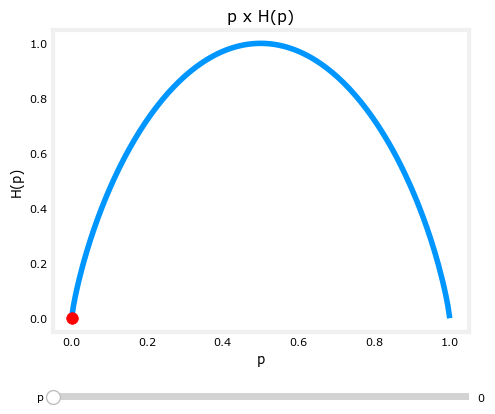

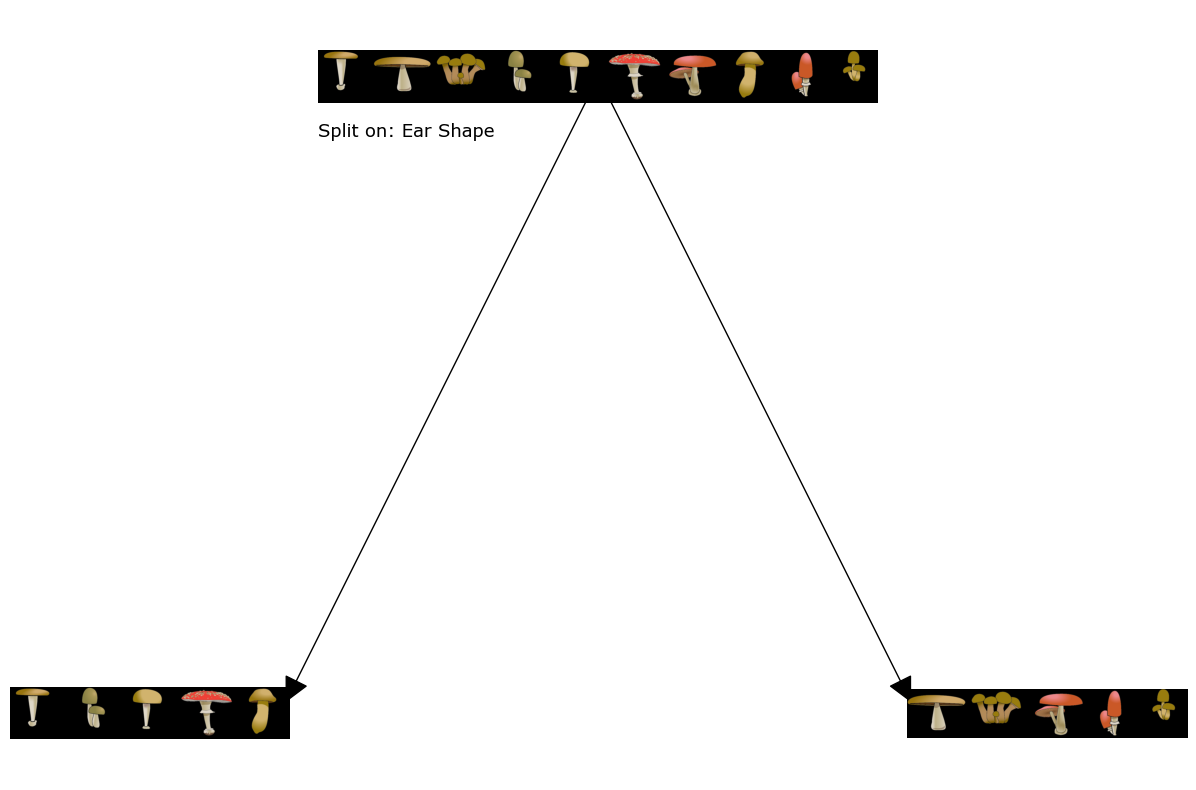

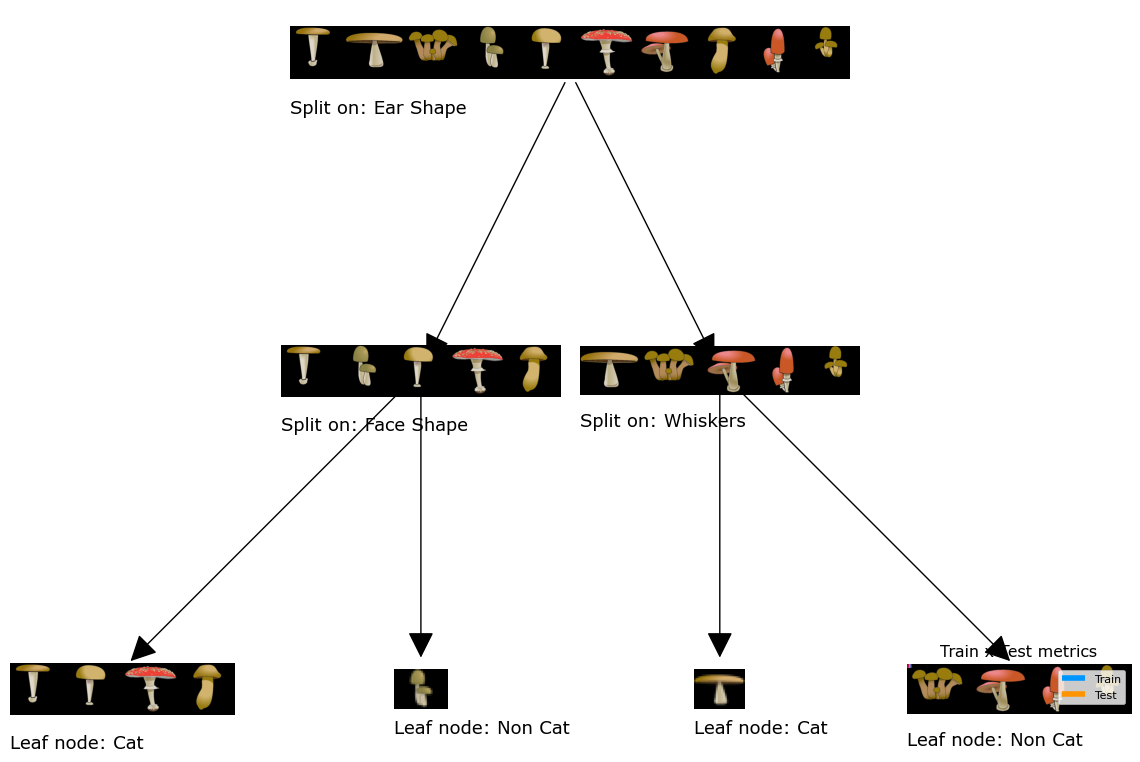

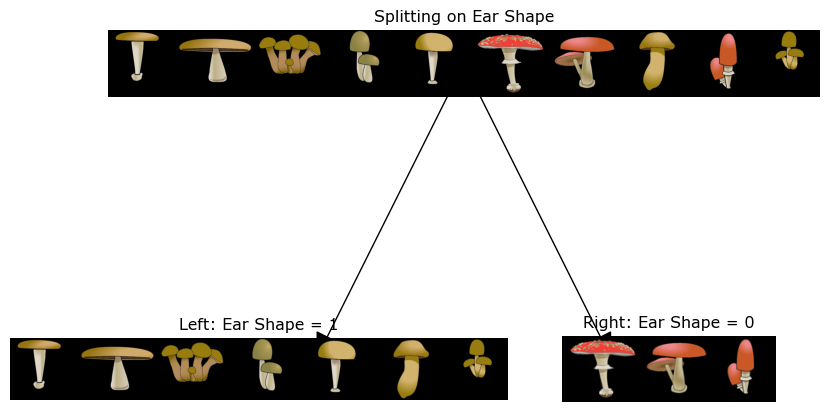


CASE 2:
Left indices:  [0, 2, 4]
Right indices:  [6, 8]


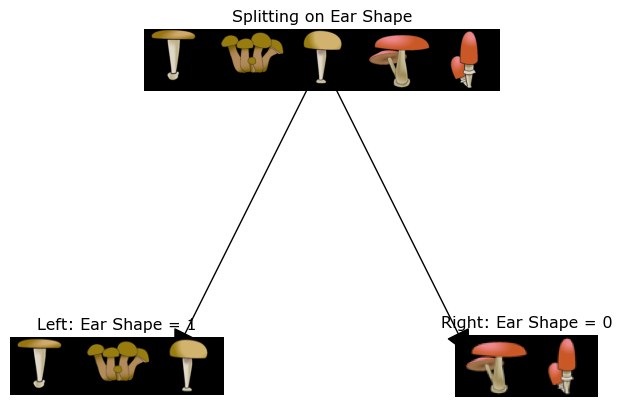

 All tests passed.


In [52]:
# Case 1

root_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Feel free to play around with these variables
# The dataset only has three features, so this value can be 0 (Brown Cap), 1 (Tapering Stalk Shape) or 2 (Solitary)
feature = 0

left_indices, right_indices = split_dataset(X_train, root_indices, feature)

print("CASE 1:")
print("Left indices: ", left_indices)
print("Right indices: ", right_indices)

# Visualize the split 
generate_split_viz(root_indices, left_indices, right_indices, feature)

print()

# Case 2

root_indices_subset = [0, 2, 4, 6, 8]
left_indices, right_indices = split_dataset(X_train, root_indices_subset, feature)

print("CASE 2:")
print("Left indices: ", left_indices)
print("Right indices: ", right_indices)

# Visualize the split 
generate_split_viz(root_indices_subset, left_indices, right_indices, feature)

# UNIT TESTS    
split_dataset_test(split_dataset)

**Expected Output**:
```
CASE 1:
Left indices:  [0, 1, 2, 3, 4, 7, 9]
Right indices:  [5, 6, 8]

CASE 2:
Left indices:  [0, 2, 4]
Right indices:  [6, 8]
```

<a name="4.3"></a>
### 4.3  Calculate information gain

Next, you'll write a function called `information_gain` that takes in the training data, the indices at a node and a feature to split on and returns the information gain from the split.

<a name="ex03"></a>
### Exercise 3

Please complete the `compute_information_gain()` function shown below to compute

$$\text{Information Gain} = H(p_1^\text{node})- (w^{\text{left}}H(p_1^\text{left}) + w^{\text{right}}H(p_1^\text{right}))$$

where 
- $H(p_1^\text{node})$ is entropy at the node 
- $H(p_1^\text{left})$ and $H(p_1^\text{right})$ are the entropies at the left and the right branches resulting from the split
- $w^{\text{left}}$ and $w^{\text{right}}$ are the proportion of examples at the left and right branch, respectively

Note:
- You can use the `compute_entropy()` function that you implemented above to calculate the entropy
- We've provided some starter code that uses the `split_dataset()` function you implemented above to split the dataset 

If you get stuck, you can check out the hints presented after the cell below to help you with the implementation.

In [53]:
# UNQ_C3
# GRADED FUNCTION: compute_information_gain

def compute_information_gain(X, y, node_indices, feature):
    
    """
    Compute the information of splitting the node on a given feature
    
    Args:
        X (ndarray):            Data matrix of shape(n_samples, n_features)
        y (array like):         list or ndarray with n_samples containing the target variable
        node_indices (ndarray): List containing the active indices. I.e, the samples being considered in this step.
        feature (int):           Index of feature to split on
   
    Returns:
        cost (float):        Cost computed
    
    """    
    # Split dataset
    left_indices, right_indices = split_dataset(X, node_indices, feature)
    
    # Some useful variables
    X_node, y_node = X[node_indices], y[node_indices]
    X_left, y_left = X[left_indices], y[left_indices]
    X_right, y_right = X[right_indices], y[right_indices]
    
    # You need to return the following variables correctly
    information_gain = 0
    
    ### START CODE HERE ###

    node_entropy = compute_entropy(y_node)
    left_entropy = compute_entropy(y_left)
    right_entropy = compute_entropy(y_right)

    w_left = len(X_left) / len(X_node)

    w_right = len(X_right) / len(X_node)

    weighted_entropy = w_left * left_entropy + w_right * right_entropy

    information_gain = node_entropy - weighted_entropy

    ### END CODE HERE ###  
    
    return information_gain

You can now check your implementation using the cell below and calculate what the information gain would be from splitting on each of the featues

In [54]:
info_gain0 = compute_information_gain(X_train, y_train, root_indices, feature=0)
print("Information Gain from splitting the root on brown cap: ", info_gain0)

info_gain1 = compute_information_gain(X_train, y_train, root_indices, feature=1)
print("Information Gain from splitting the root on tapering stalk shape: ", info_gain1)

info_gain2 = compute_information_gain(X_train, y_train, root_indices, feature=2)
print("Information Gain from splitting the root on solitary: ", info_gain2)

# UNIT TESTS
compute_information_gain_test(compute_information_gain)

Information Gain from splitting the root on brown cap:  0.034851554559677034
Information Gain from splitting the root on tapering stalk shape:  0.12451124978365313
Information Gain from splitting the root on solitary:  0.2780719051126377
 All tests passed.


**Expected Output**:
```
Information Gain from splitting the root on brown cap:  0.034851554559677034
Information Gain from splitting the root on tapering stalk shape:  0.12451124978365313
Information Gain from splitting the root on solitary:  0.2780719051126377
```

Splitting on "Solitary" (feature = 2) at the root node gives the maximum information gain. Therefore, it's the best feature to split on at the root node.

<a name="4.4"></a>
### 4.4  Get best split
Now let's write a function to get the best feature to split on by computing the information gain from each feature as we did above and returning the feature that gives the maximum information gain

<a name="ex04"></a>
### Exercise 4
Please complete the `get_best_split()` function shown below.
- The function takes in the training data, along with the indices of datapoint at that node
- The output of the function is the feature that gives the maximum information gain 
    - You can use the `compute_information_gain()` function to iterate through the features and calculate the information for each feature
If you get stuck, you can check out the hints presented after the cell below to help you with the implementation.

In [55]:
# UNQ_C4
# GRADED FUNCTION: get_best_split

def get_best_split(X, y, node_indices):   
    """
    Returns the optimal feature and threshold value
    to split the node data 
    
    Args:
        X (ndarray):            Data matrix of shape(n_samples, n_features)
        y (array like):         list or ndarray with n_samples containing the target variable
        node_indices (ndarray): List containing the active indices. I.e, the samples being considered in this step.

    Returns:
        best_feature (int):     The index of the best feature to split
    """    
    
    # Some useful variables
    num_features = X.shape[1]
    
    # You need to return the following variables correctly
    best_feature = -1
    
    ### START CODE HERE ###
    max_info_gain = 0
    for i in range(num_features):
        if compute_information_gain(X, y, node_indices, i) > max_info_gain:
            max_info_gain = compute_information_gain(X, y, node_indices, i) 
            best_feature = i
            
    ### END CODE HERE ##    
   
    return best_feature

Now, let's check the implementation of your function using the cell below.

In [56]:
best_feature = get_best_split(X_train, y_train, root_indices)
print("Best feature to split on: %d" % best_feature)

# UNIT TESTS
get_best_split_test(get_best_split)

Best feature to split on: 2
 All tests passed.


As we saw above, the function returns that the best feature to split on at the root node is feature 2 ("Solitary")

<a name="5"></a>
## 5 - Building the tree

In this section, we use the functions you implemented above to generate a decision tree by successively picking the best feature to split on until we reach the stopping criteria (maximum depth is 2).

You do not need to implement anything for this part.

In [57]:
# Not graded
tree = []

def build_tree_recursive(X, y, node_indices, branch_name, max_depth, current_depth):
    """
    Build a tree using the recursive algorithm that split the dataset into 2 subgroups at each node.
    This function just prints the tree.
    
    Args:
        X (ndarray):            Data matrix of shape(n_samples, n_features)
        y (array like):         list or ndarray with n_samples containing the target variable
        node_indices (ndarray): List containing the active indices. I.e, the samples being considered in this step.
        branch_name (string):   Name of the branch. ['Root', 'Left', 'Right']
        max_depth (int):        Max depth of the resulting tree. 
        current_depth (int):    Current depth. Parameter used during recursive call.
   
    """ 

    # Maximum depth reached - stop splitting
    if current_depth == max_depth:
        formatting = " "*current_depth + "-"*current_depth
        print(formatting, "%s leaf node with indices" % branch_name, node_indices)
        return
   
    # Otherwise, get best split and split the data
    # Get the best feature and threshold at this node
    best_feature = get_best_split(X, y, node_indices) 
    
    formatting = "-"*current_depth
    print("%s Depth %d, %s: Split on feature: %d" % (formatting, current_depth, branch_name, best_feature))
    
    # Split the dataset at the best feature
    left_indices, right_indices = split_dataset(X, node_indices, best_feature)
    tree.append((left_indices, right_indices, best_feature))
    
    # continue splitting the left and the right child. Increment current depth
    build_tree_recursive(X, y, left_indices, "Left", max_depth, current_depth+1)
    build_tree_recursive(X, y, right_indices, "Right", max_depth, current_depth+1)

 Depth 0, Root: Split on feature: 2
- Depth 1, Left: Split on feature: 0
  -- Left leaf node with indices [0, 1, 4, 7]
  -- Right leaf node with indices [5]
- Depth 1, Right: Split on feature: 1
  -- Left leaf node with indices [8]
  -- Right leaf node with indices [2, 3, 6, 9]


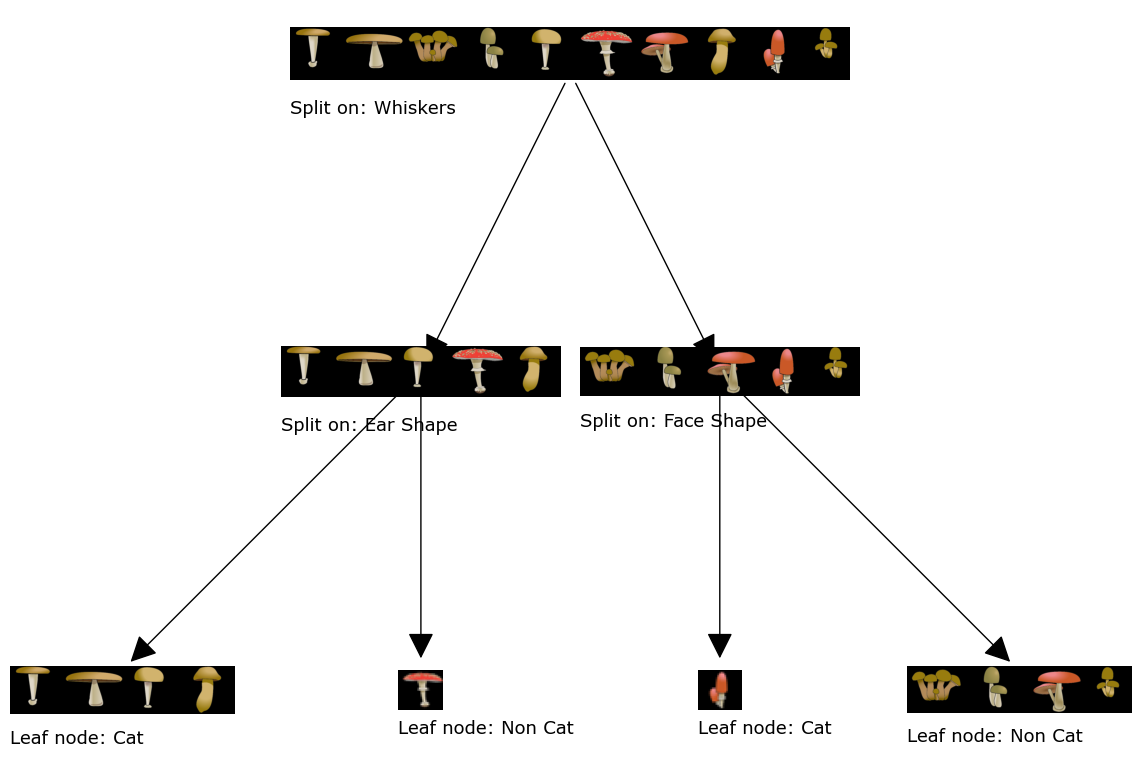

In [58]:
build_tree_recursive(X_train, y_train, root_indices, "Root", max_depth=2, current_depth=0)
generate_tree_viz(root_indices, y_train, tree)